# 循环神经网络

## 1 循环神经网络模块
RNN无法有效应对长时依赖问题，时间跨度较大，所以会丢失较前的信息，LSTM (Long Short Term Memory Networks)和GRU (Gated Recurrent Unit)可以一定程度上解决长时依赖问题，但后来提出的注意力attention机制会更加有效

### 1.1 原始RNN
网络有两个输入：当前时刻$t$的输入$x_t$和$t-1$时刻的隐藏状态$h_{t-1}$
- $x_t$的维度：**(seq, batch, feature)**，分别表示序列长度、批量和输入特征维度
- $h_{t-1}$的维度：**(layers*direction, batch, hidden)**，分别表示层数乘方向(单向为1，双向为2)，批量和输出维度

网络有两个输出：当前时刻$t$的输出$output$和隐藏状态$h_t$
- $output$的维度：**(seq, batch, hidden*direction)**，分别表示序列长度，批量和输出维度乘方向(单向为1，双向为2)
- $h_t$的维度：**(layers*direction, batch, hidden)**，分别表示层数乘方向(单向为1，双向为2)，批量和输出维度

**注意**：$h_{t-1}$和 $h_t$的维度是一致的；在网络初始化时有隐藏状态$h_0$，可以自己指定，如果不指定则默认为0；在单向的RNN中每层只有一个记忆单元，双向的有两个

RNN的内部网络计算公式：
$$h_t=tanh(w_{ih}*x_t+b_{ih}+w_{hh}*h_{t-1}+b_{hh})$$

在PyTorch中使用`nn.RNN(*args, **kargs)`定义，根据参数的定义形式使用`nn.RNN(input_size=20, hidden_size=50, num_layers=2)`和`nn.RNN(20, 50, 2)`定义的结果一致，参数列表如下：

|参数|功能|
|-|-|
|input_size|输入$x_t$的特征维度|
|hidden_size|输出(隐藏状态)$h_t$的特征维度|
|num_layers|网络层数，默认为**1**|
|nonlinearity|非线性激活函数，默认tanh，可选relu|
|bias|是否使用偏置，默认使用**True**|
|batch_first|决定网络输入维度的顺序，默认顺序为<br>**(seq, batch, feature)**,如果设置为True，<br>顺序变为(batch, seq, feature)|
|dropout|参数接收0~1的数值，在除最后一层外<br>的其他层加dropout层，默认为**0**|
|bidirectional|设置为True表示双向循环神经网络，<br>默认**False**|

### 注意：0.4版本开始的新规范，Variable和tensor合并后程序有所不同
参考：[Variable和Tensor合并后，PyTorch的代码要怎么改](https://blog.csdn.net/dQCFKyQDXYm3F8rB0/article/details/80105285)
从0.4版本开始程序框架如下：
```python
# torch.device object used throughout this script
device = torch.device("cuda" if use_cuda else "cpu")
model = MyRNN().to(device)
 
# train
total_loss = 0
for input, target in train_loader:
     input, target = input.to(device), target.to(device)
     hidden = input.new_zeros(*h_shape) 
     # has the same device & dtype as `input`
     ...  # get loss and optimize
     total_loss += loss.item() # get Python number from 1-element Tensor

# evaluate
with torch.no_grad():          # operations inside don't track history
     for input, target in test_loader:
```

其他修改部分：
1. 使用`x.detach()`代替Variable中的`x.data`来修改数据，仅**原地**修改可改变原tensor
2. 损失函数中使用`loss.item()`代替`loss.data[0]`来获取python数值
3. 使用`tensor.type()`输出tensor的类型
4. `torch.no_grad()`代替`volatile`标志位
5. 可以创建零维向量，如`torch.tensor(2)`，更类似于`numpy.array()`函数
```python
print(torch.tensor(2))  # 只指定数据
print(torch.Tensor(2))  # 既可以指定数据，也可以指定维度来随机数据
# tensor(2)
# tensor(1.00000e-45 *
#      [ 1.4013,  0.0000])
```

注意：


- 训练网络的时候把模型和数据都放到GPU上，测试的时候放到CPU上，因为cuda的变量无法直接转变为numpy的变量，测试会涉及到可视化等分析步骤，用numpy数据更佳
- `model.to(device)`的方法不依赖设备更加通用，`model.cpu()`或`model.cuda()`转换模型的计算方式(变量同理)

In [1]:
import os
import torch
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.utils.model_zoo as model_zoo
from torchvision import transforms, datasets, models

# 优先使用GPU
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')

In [2]:
basic_rnn = nn.RNN(input_size=20, hidden_size=50, num_layers=2)
print('1.weight_ih的两个权重:', basic_rnn.weight_ih_l0.shape, basic_rnn.weight_ih_l1.shape)
print('  bias_ih的权重:', basic_rnn.bias_ih_l0.shape, basic_rnn.bias_ih_l1.shape)
print('2.weight_hh的两个权重:', basic_rnn.weight_hh_l0.shape, basic_rnn.weight_hh_l1.shape)
print('  bias_hh的权重:', basic_rnn.bias_hh_l0.shape, basic_rnn.bias_hh_l1.shape)

1.weight_ih的两个权重: torch.Size([50, 20]) torch.Size([50, 50])
  bias_ih的权重: torch.Size([50]) torch.Size([50])
2.weight_hh的两个权重: torch.Size([50, 50]) torch.Size([50, 50])
  bias_hh的权重: torch.Size([50]) torch.Size([50])


In [3]:
# 随机化初始输入xt和隐藏状态h0
toy_input = torch.randn([100, 32, 20])            # [seq, batch, feature] 
h_0 = torch.randn([2, 32, 50])                    # [layers*direction, batch, hidden_size]
toy_output, h_n = basic_rnn(toy_input, h_0)
print('1.RNN的输出output:', toy_output.shape)      # [seq, batch, hidden_size*direction] 
print('2.RNN的输出隐层状态:', h_n.shape)           # [layers*direction, batch, hidden_size]

1.RNN的输出output: torch.Size([100, 32, 50])
2.RNN的输出隐层状态: torch.Size([2, 32, 50])


小结：
- 在一层的RNN中，如果是非双向循环的网络，一般只有一个记忆单元，所以隐藏状态的第一维度都是1，双向的网络为2，不同的层有各自的记忆单元，所以隐藏状态$h_t$的第一维度为：**layers*direction**，双向网络direction为2，普通的为1
- 下面程序用于显示进度，以后可能会用，注意print函数中设置`end='\r'`可以覆盖原输出
```python
def show_progress():
    process = '<' + '.'*25 + '>'
    for i in range(1, 26):
        time.sleep(0.5)
        process= process.replace('.', '=', 1)
        print(process, end='\r')
    print('\nfinished!')
# 输出
# <=========================>
# finished!
```

In [4]:
# pytorch中的detach用法
t1 = torch.FloatTensor([1., 2.])
v1 = Variable(t1)
t2 = torch.FloatTensor([2., 3.])
v2 = Variable(t2)
v3 = v1 + v2
v3_detached = v3.detach()      # 只能原地修改
v3_detached.data.add_(t1*2)    # 修改了 v3_detached Variable中 tensor 的值
print(v3, v3_detached)         # v3 中tensor 的值也会改变

tensor([5., 9.]) tensor([5., 9.])


### 1.2 LSTM与GRU
本质上与RNN一样，只是内部计算更复杂，参数更多
- LSTM做了4次类似标准RNN的运算，所以参数是标准RNN的4倍，隐藏状态为$h_0$和$c_0$，维度均是**(layers*direction, batch, hidden_size)**，direction：单向为1，双向为2
- GRU参数是标准RNN的3倍，隐藏状态只有$h_0$，维度同上
- LSTM与GRU的定义方法基本与标准RNN的一样，但无nonlinearity参数，其他可参考标准RNN

In [5]:
# 1. 定义lstm
# 参数维度4翻倍：[output_size*4, input_size]
lstm = nn.LSTM(input_size=20, hidden_size=50, num_layers=2)
print('1.weight_ih的两个权重:', lstm.weight_ih_l0.shape, lstm.weight_ih_l1.shape)
print('  bias_ih的权重:', lstm.bias_ih_l0.shape, lstm.bias_ih_l1.shape)
print('2.weight_hh的两个权重:', lstm.weight_hh_l0.shape, lstm.weight_hh_l1.shape)
print('  bias_hh的权重:', lstm.bias_hh_l0.shape, lstm.bias_hh_l1.shape)

1.weight_ih的两个权重: torch.Size([200, 20]) torch.Size([200, 50])
  bias_ih的权重: torch.Size([200]) torch.Size([200])
2.weight_hh的两个权重: torch.Size([200, 50]) torch.Size([200, 50])
  bias_hh的权重: torch.Size([200]) torch.Size([200])


In [6]:
toy_input = torch.randn([100, 32, 20])            # [seq, batch, feature] 
lstm_out, (h_n, c_n) = lstm(toy_input)
print(lstm_out.shape)        # [seq, batch, hidden*direction]
print(h_n.shape)             # [layers*direction, batch, hidden]
print(c_n.shape)             # [layers*direction, batch, hidden]

torch.Size([100, 32, 50])
torch.Size([2, 32, 50])
torch.Size([2, 32, 50])


In [7]:
# 2. 定义GRU
gru = nn.GRU(input_size=20, hidden_size=50, num_layers=2)
print('1.weight_ih的两个权重:', gru.weight_ih_l0.shape, gru.weight_ih_l1.shape)
print('  bias_ih的权重:', gru.bias_ih_l0.shape, gru.bias_ih_l1.shape)
print('2.weight_hh的两个权重:', gru.weight_hh_l0.shape, gru.weight_hh_l1.shape)
print('  bias_hh的权重:', gru.bias_hh_l0.shape, gru.bias_hh_l1.shape)

1.weight_ih的两个权重: torch.Size([150, 20]) torch.Size([150, 50])
  bias_ih的权重: torch.Size([150]) torch.Size([150])
2.weight_hh的两个权重: torch.Size([150, 50]) torch.Size([150, 50])
  bias_hh的权重: torch.Size([150]) torch.Size([150])


In [8]:
gru_out, h_n = gru(toy_input)
print(gru_out.shape)         # [seq, batch, hidden*direction]
print(h_n.shape)             # [layers*direction, batch, hidden]

torch.Size([100, 32, 50])
torch.Size([2, 32, 50])


小结:
- nn.RNN、nn.LSTM和nn.GRU定义的是完整序列的网络，而RNNCell、LSTMCell和GRUCell定义单步的网络，即只是序列中的一步，循环神经网络的一个循环

## 2 循环神经网络实例

### 2.1 图像分类
这里使用MNIST数据集，该数据集中图像是28*28的，可以将图像看作长为28的序列，序列中每个元素特征维度为28，将图像序列化后可以用RNN来处理

In [9]:
# 1.导入数据
data_tf =transforms.Compose([
    transforms.ToTensor(),                   # 将图像转换为[0~1]的tensor
    transforms.Normalize([0.5], [0.5])       # 标准化到[-1,1]
])
# 导入MNIST数据集
train_datasets = datasets.MNIST(root='./data/MNIST', train=True, transform=data_tf, download=False)
test_datasets = datasets.MNIST(root='./data/MNIST', train=False, transform=data_tf)

# [b,28,28] 可以看作 [batch, seq, feature]的序列化数据
train_loader = DataLoader(train_datasets, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_datasets, batch_size=64, shuffle=False)

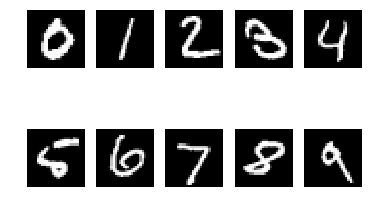

In [10]:
# 显示数据
def show():
    labels = test_datasets.test_labels.numpy()  # 没有经过transforms的数据
    data = test_datasets.test_data.numpy()
    # np.where获得结果:(array([1,...], dtype=int64), )，所以使用[0][index]获取元素
    sample_index = [np.where(labels==i)[0][0] for i in range(10)]
    sample_data = data[sample_index]
    for i in range(10):
        plt.subplot(2, 5, i+1)
        plt.axis('off')
        plt.imshow(sample_data[i], cmap='gray')
show()

In [11]:
# 创建序列化图像的生成器，为训练模型提供批次数据(该函数不是必须的)
# [b,28,28] -> [b, seq, feature]
def generator(batch_size=32, train=True, shuffle=True):
    datasets = train_datasets if train else test_datasets
    # 先生成批次的数据
    loader = DataLoader(datasets, batch_size=batch_size, shuffle=shuffle, num_workers=4)
    for data in loader:
       yield data[0], data[1] 

In [12]:
# 2.定义模型
class RNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layers, n_classes):
        super().__init__() 
        self.n_layers = n_layers       # RNN层数
        self.n_classes = n_classes     # 输出类别数
        self.hidden_dim = hidden_dim   # 隐藏状态特征数
        self.lstm = nn.LSTM(input_size=in_dim, hidden_size=hidden_dim, 
                            num_layers=n_layers, batch_first=True)
        # batch_first 使输入为 [batch, seq, input_dim]
        self.classifier = nn.Linear(hidden_dim, n_classes)   # 分类
    def forward(self, x):
        lstm_out, _ = self.lstm(x)     # 传入网络 get [batch,seq,hidden]
        out = lstm_out[:, -1, :]       # 获取序列的最后输出 get [batch,hidden]
#         print(out.shape)             # get [batch, hidden]
        out = self.classifier(out)     # get [batch, n_classes] 
#         print(out.shape)
        return out
    

In [18]:
# 定义损失函数及优化函数
rnn_model = RNN(28,256,2,10)           # 创建模型
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=1e-2)
type(rnn_model)

__main__.RNN

In [19]:
# 3.训练模型
batch_size = 32      # 定义batch_size
epochs = 1           # 定义epoch最大次数
max_batches = np.ceil(len(train_datasets) / batch_size)*epochs
# print(max_batches)

def train(model, batch_size, epochs, save_path='./model'):
    num_batches = 0                                    # 记录batches的数目
    train_loader = DataLoader(train_datasets, batch_size=batch_size, shuffle=True,
                             num_workers=4) 
    model.to(device)
    for epoch in range(epochs):
        print('-'*20)
        print('Epoch {}'.format(epoch+1))
        for data in train_loader: 
            # 将变量及模型放到GPU上
            x_train, y_train = data   # x维度 [b,1,28,28]
            x_train = x_train[:,0]    # x维度 [b,28,28]
            x_train, y_train = x_train.to(device), y_train.to(device)
#             print(x_train.shape)
            # forward + backward + optimizer    
            out = model(x_train)                  # 计算输出
            loss = criterion(out, y_train)        # 计算损失函数
            print_loss = loss.item()
            optimizer.zero_grad()                 # 梯度归零
            loss.backward()                       # 反向传播
            optimizer.step()                      # 更新参数
#             print(num_batches)
                        
            if (num_batches) % 100 == 0:
#                 print(type(model))
                print('Batches {} loss {:.4f}'.format(num_batches, print_loss))
            num_batches += 1
            if num_batches == 1000:               # 为了快速验证程序，中断训练
                break
    # 存储路径        
    save_path = os.path.join(save_path, 'rnn_{}.pth'.format(num_batches))   
    torch.save(model, save_path)                #存储路径
     
train(rnn_model, batch_size, epochs)         # 训练网络

--------------------
Epoch 1
Batches 0 loss 2.3053
Batches 100 loss 1.0990
Batches 200 loss 0.8368
Batches 300 loss 0.2619
Batches 400 loss 0.3684
Batches 500 loss 0.5868
Batches 600 loss 0.7592
Batches 700 loss 0.3227
Batches 800 loss 0.4057
Batches 900 loss 0.1243


D:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [23]:
# 5.评价模型的性能
def test(model, batch_size=32):
    test_loader = DataLoader(test_datasets, batch_size=batch_size, shuffle=False)
    
    model.eval()      # 将模型转换为测试状态
    total_loss = 0
    total_acc = 0
    test_epoch = 0 
    for data in test_loader:
        eval_loss = 0
        eval_acc = 0
        img, label = data      # 获取测试数据
        img = img[:,0]
    #     print(img.shape)
        # 由于测试状态下不需方向传播，所以可以释放缓存
        with torch.no_grad():

            img, label = img.to(device), label.to(device)
            out = model(img)     # 计算图像的标签 [img.size(0), 10]
            loss = criterion(out, label)
            eval_loss += loss.data* label.size(0)   # 计算该批次的总损失
            _, pred = torch.max(out, 1)          # 在一行内按列比大小得[64,1],tenso为[64]
        #     print(_, pred.shape)
            num_correct = (pred == label).sum()
            eval_acc += num_correct.data
        #     print(eval_acc)    
            total_loss += eval_loss    # 累计所有批次数据的损失和准确率
            total_acc  += eval_acc
            if (test_epoch + 1) % 10 == 0:
                batch_loss  = (eval_loss / img.size(0))        # 计算该批次的损失
                batch_acc   = (eval_acc.float() / img.size(0)) # 计算该批次的准确率
                print('Epoch: {} Test Loss: {:.6f}, ACC: {:.6f}'.format(test_epoch+1, batch_loss, batch_acc))
            test_epoch += 1
    print('----------Test Done!----------')
    print('Epoch: {} Total_Loss: {:.6f} Total_ACC: {:.6f}'.format(\
          test_epoch, total_loss/len(test_datasets), float(total_acc)/len(test_datasets)))
save_model = torch.load('./model/rnn_1000.pth')
save_model.to(device)
test(save_model)         # 评估模型性能

Epoch: 10 Test Loss: 0.332930, ACC: 0.906250
Epoch: 20 Test Loss: 0.530187, ACC: 0.875000
Epoch: 30 Test Loss: 0.382257, ACC: 0.875000
Epoch: 40 Test Loss: 0.368515, ACC: 0.875000
Epoch: 50 Test Loss: 0.474718, ACC: 0.781250
Epoch: 60 Test Loss: 0.434582, ACC: 0.875000
Epoch: 70 Test Loss: 0.398774, ACC: 0.875000
Epoch: 80 Test Loss: 0.546223, ACC: 0.875000
Epoch: 90 Test Loss: 0.303690, ACC: 0.875000
Epoch: 100 Test Loss: 0.079886, ACC: 1.000000
Epoch: 110 Test Loss: 0.376336, ACC: 0.843750
Epoch: 120 Test Loss: 0.515528, ACC: 0.843750
Epoch: 130 Test Loss: 0.701372, ACC: 0.750000
Epoch: 140 Test Loss: 0.368030, ACC: 0.843750
Epoch: 150 Test Loss: 0.069468, ACC: 1.000000
Epoch: 160 Test Loss: 0.168973, ACC: 0.906250
Epoch: 170 Test Loss: 0.042365, ACC: 1.000000
Epoch: 180 Test Loss: 0.660746, ACC: 0.843750
Epoch: 190 Test Loss: 0.519290, ACC: 0.875000
Epoch: 200 Test Loss: 0.189386, ACC: 0.937500
Epoch: 210 Test Loss: 0.319277, ACC: 0.906250
Epoch: 220 Test Loss: 0.147183, ACC: 0.9687